## Описание проекта
Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.  

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

# 1. Исследовательский анализ данных

Загружаем необходимые библиотеки.

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

Прочтем данные.

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Имеем список названий файлов с фото с указанием возраста человека на фото. Посмотрим на распределение возрастов.

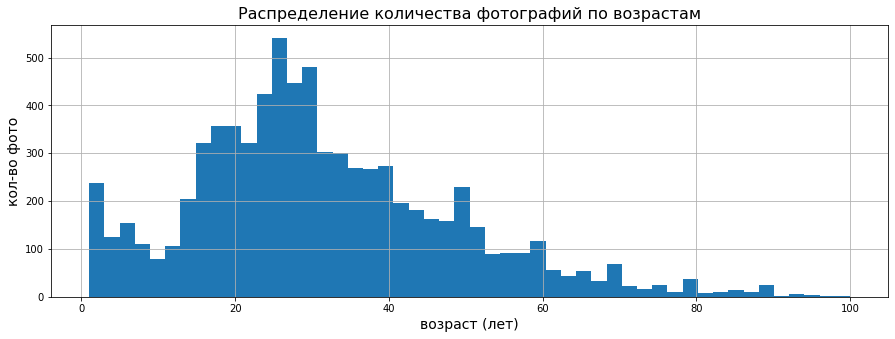

In [5]:
plt.figure(figsize=(15, 5))
plt.title('Распределение количества фотографий по возрастам', size=16)
labels['real_age'].hist(bins=50);
plt.xlabel('возраст (лет)', size=14)
plt.ylabel('кол-во фото', size=14);

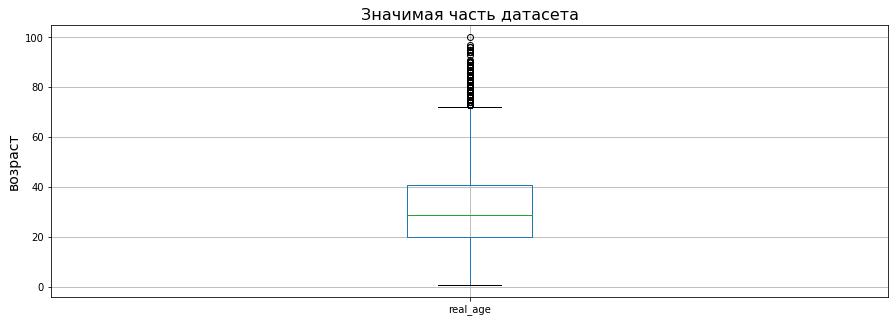

In [6]:
plt.figure(figsize=(15, 5))
plt.title('Значимая часть датасета', size=16)
pd.DataFrame(labels['real_age']).boxplot();
plt.ylabel('возраст', size=14);

Основное количество фотографий 25-ти - 30-ти летних. Но много и младенцев. Посмотрим фотки, выведем на экран 12шт.

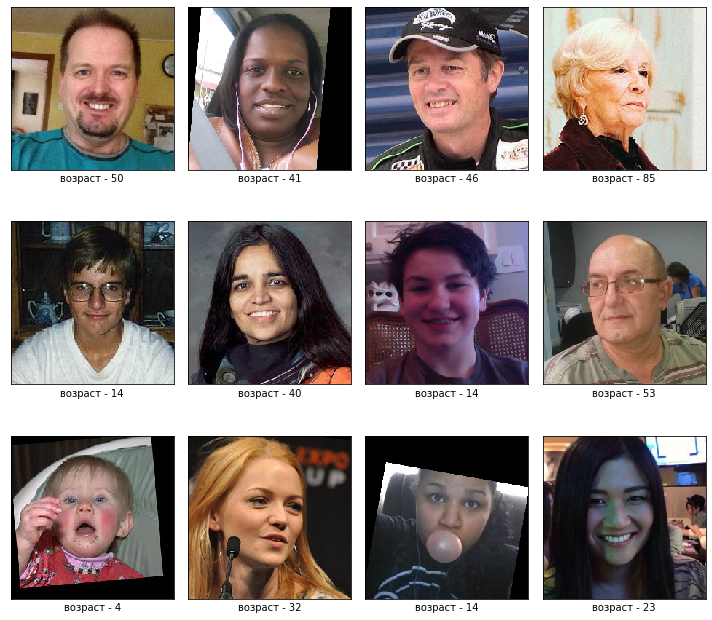

In [7]:
features, target = next(gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xlabel('возраст - ' + str(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Будем использовать архитектуру ResNet50 с предобучением классификации на датасете ImageNet. В конце добавим два слоя:  
GlobalAveragePooling2D для усреднения информации по всему изображению  
Dense — полносвязный слой для классификации с 1-м нейроном и функцией активации ReLU.  
Для автоматического подбора шага используем алгоритм оптимизации Adam со стартовым шагом градиентного спуска 0.0001 .  
Функцию потерь установим MSE - с ней сети обучаются быстрее.  
Для обучения ограничимся 10-ю эпохами.

В датасете 7591 фотография, для обучения маловато, но нам на помощь приходит уже предобученная нейросеть ResNet50. На всех фото  - головы (лица). Но!! кто-то в очках, кто-то с бородой, с ложкой, улыбающиеся, хмурые, с макияжем, в головных уборах, видел женщину с заклееным скотчем ртом. Различный пол и расовая принадлежность.  

# 2. Обучение модели

#### Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке.
```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_gen_flow



def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_gen_flow



def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)        
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    model.compile(optimizer=Adam(lr=0.0001), loss='mse',
                  metrics=['mae'])
    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)   
        
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

#### Результат.
```
Using TensorFlow backend.
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 51s - loss: 223.3285 - mae: 10.7170 - val_loss: 742.5389 - val_mae: 22.3163
Epoch 2/10
178/178 - 40s - loss: 63.7150 - mae: 6.0222 - val_loss: 594.1650 - val_mae: 19.3074
Epoch 3/10
178/178 - 40s - loss: 30.6770 - mae: 4.2551 - val_loss: 476.9968 - val_mae: 16.8984
Epoch 4/10
178/178 - 40s - loss: 19.1773 - mae: 3.3566 - val_loss: 120.1221 - val_mae: 8.2743
Epoch 5/10
178/178 - 40s - loss: 14.6596 - mae: 2.9771 - val_loss: 81.9645 - val_mae: 6.8368
Epoch 6/10
178/178 - 40s - loss: 13.1486 - mae: 2.8212 - val_loss: 74.7562 - val_mae: 6.4535
Epoch 7/10
178/178 - 40s - loss: 11.3109 - mae: 2.5885 - val_loss: 70.0077 - val_mae: 6.3506
Epoch 8/10
178/178 - 40s - loss: 9.0768 - mae: 2.3072 - val_loss: 66.7408 - val_mae: 6.1927
Epoch 9/10
178/178 - 40s - loss: 7.5576 - mae: 2.0798 - val_loss: 79.6188 - val_mae: 6.7272
Epoch 10/10
178/178 - 40s - loss: 7.0779 - mae: 2.0251 - val_loss: 65.7554 - val_mae: 6.1027
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 65.7554 - mae: 6.1027
Test MAE: 6.1027



```

#### Добавим аугментацию.  
В функцию загрузки train-выборки добавим отображение по горизонтали (т.е просто отзеркалим фотографии).

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')

    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
    return train_gen_flow

#### Результат с аугментацией.
Epoch 1/10  
178/178 - 50s - loss: 209.8487 - mae: 10.5127 - val_loss: 750.9266 - val_mae: 22.4747  
Epoch 2/10  
178/178 - 39s - loss: 73.4433 - mae: 6.4681 - val_loss: 841.2326 - val_mae: 24.0358  
Epoch 3/10  
178/178 - 40s - loss: 47.4013 - mae: 5.2595 - val_loss: 241.8242 - val_mae: 11.3494  
Epoch 4/10  
178/178 - 40s - loss: 34.0883 - mae: 4.4480 - val_loss: 138.8236 - val_mae: 8.8105  
Epoch 5/10  
178/178 - 39s - loss: 26.4764 - mae: 3.9329 - val_loss: 76.9981 - val_mae: 6.6125  
Epoch 6/10  
178/178 - 39s - loss: 20.7441 - mae: 3.4841 - val_loss: 101.9452 - val_mae: 8.0101  
Epoch 7/10  
178/178 - 39s - loss: 17.5494 - mae: 3.1919 - val_loss: 66.2044 - val_mae: 6.0731  
Epoch 8/10  
178/178 - 39s - loss: 14.6758 - mae: 2.9620 - val_loss: 89.5972 - val_mae: 7.3912  
Epoch 9/10  
178/178 - 39s - loss: 11.6477 - mae: 2.6004 - val_loss: 90.5498 - val_mae: 7.1404  
Epoch 10/10  
178/178 - 40s - loss: 10.7677 - mae: 2.4886 - val_loss: 60.2240 - val_mae: 5.8549  
WARNING:tensorflow:sample_weight modes were coerced from  
  ...  
    to    
  ['...']  
60/60 - 9s - loss: 60.2240 - mae: 5.8549  
Test MAE: 5.8549  

Метрика MAE после аугментации несколько уменьшилась (хотя её стало болтать от эпохи к эпохе, возможно, с увеличением кол-ва эпох эта болтанка уменьшится). Отражение по вертикали, например, даёт увеличение метрики, видимо, перевернутые фотки не лучшая форма обучения.

# 3. Анализ обученной модели

Итак, после обучения сверточной нейронной сети мы получили значение MAE для тестовой выборки 5.85, задача решена. Модель определяет возраст человека со средней ошибкой 6 лет. Для детей это, конечно, много, для них нужно проводить отдельное обучение на детских фотографиях, их можно отнести в одну категорию, например "дети до 12 лет" (дети являются мощнейшим стимулом для покупок родителей).  
Что касается второй задачи по продаже алкоголя, то, возможно, к определению возраста (18+6=24) следует прибавить еще пару лет для надежности (слишком уж штрафы большие). Т.е если возраст определен, как 25, то паспорт при продаже алкоголя требовать обязательно (25-8=17).
